In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Read train and test files

In [2]:
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')

print(train_df.shape)
train_df.head()

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
submission_df = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(5506, 3)


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [4]:
unique_submission_images = submission_df['ImageId'].unique()
len(unique_submission_images)

5506

In [5]:
submission_df = pd.DataFrame(unique_submission_images, columns=['ImageId'])
print(submission_df.shape)
submission_df.head()

(5506, 1)


,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


## Combine defected and no-defect images

In [6]:
TRAIN_PATH = '../input/severstal-steel-defect-detection/train_images/'
TEST_PATH = '../input/severstal-steel-defect-detection/test_images/'

train_flist = os.listdir(TRAIN_PATH) 

image_defects = train_df['ImageId'].unique().tolist()
image_no_defects=[item for item in train_flist if item not in image_defects]

#df_bin is the dataframe with label defect based on train_df 
df_bin = train_df.drop_duplicates(subset=['ImageId'], keep='last').copy()
df_bin.loc[:, 'defect_label'] = 1

df_noDefect_bin = pd.DataFrame(image_no_defects,columns=['ImageId'])
df_noDefect_bin.loc[:, 'defect_label'] = 0

frames = [df_bin[['ImageId', "defect_label"]], df_noDefect_bin]
df = pd.concat(frames).reset_index(drop=True)
print(df.shape)
print(df['defect_label'].value_counts())
df.head(1)

(12568, 2)
1    6666
0    5902
Name: defect_label, dtype: int64


,ImageId,defect_label
0,0002cc93b.jpg,1


## Split train data, load and resave images

In [7]:
nb_images = df.shape[0]
df_train, df_test = train_test_split(df, test_size=0.2, 
                                                    stratify = df['defect_label'], 
                                                    random_state=2021)

df_train, df_val = train_test_split(df_train, test_size=0.25, 
                                                  stratify = df_train['defect_label'],
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [8]:
IMAGE_SIZE = 64 #256

def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

train_path = '../tmp/train'
validate_path(train_path)
val_path = '../tmp/val'
validate_path(val_path)
test_path = '../tmp/test'
validate_path(test_path)

def process_img(df, train_path):
    #read image, resize and save
    for code in tqdm(df['ImageId']):
        img = load_img(
            code,
            base='../input/severstal-steel-defect-detection/train_images'
        )
        path = code.replace('.jpg', '')
        cv2.imwrite(f'{train_path}/{path}.png', img)

    df['ImageId'] = df['ImageId'].apply(lambda x: x.replace('.jpg', '.png'))
    return df
df_train = process_img(df_train,train_path)
df_val = process_img(df_val,val_path)
df_test = process_img(df_test,test_path)

100%|██████████| 2514/2514 [00:39<00:00, 64.27it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
print(df_train.shape,df_val.shape,df_test.shape)
print(df_train['defect_label'].value_counts())
print(df_val['defect_label'].value_counts())
print(df_test['defect_label'].value_counts())

(7540, 2) (2514, 2) (2514, 2)
1    3999
0    3541
Name: defect_label, dtype: int64
1    1334
0    1180
Name: defect_label, dtype: int64
1    1333
0    1181
Name: defect_label, dtype: int64


## Define ImageDataGenerator and data augmentation

In [10]:
BATCH_SIZE = 32

# Using original generator
data_generator = ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.05,
        width_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
    )
val_generator = ImageDataGenerator(
        rescale=1/255.
    )

train_gen = data_generator.flow_from_dataframe(
        df_train, 
        directory='../tmp/train',
        x_col='ImageId', 
        y_col='defect_label', 
        class_mode='raw',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        )

val_gen =  val_generator.flow_from_dataframe(
        df_val, 
        directory='../tmp/val',
        x_col='ImageId', 
        y_col='defect_label', 
        class_mode='raw',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        )
test_gen =  val_generator.flow_from_dataframe(
        df_test, 
        directory='../tmp/test',
        x_col='ImageId', 
        y_col='defect_label', 
        class_mode='raw',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        shuffle=False
        )

Found 7540 validated image filenames.
Found 2514 validated image filenames.
Found 2514 validated image filenames.


In [11]:
submission_gen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        submission_df,
        directory='../input/severstal-steel-defect-detection/test_images/',
        x_col='ImageId',
        class_mode=None,
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

Found 5506 validated image filenames.


## Define Model

In [12]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
prob_drop_hidden = 0.5

def build_model():
    model = Sequential()

    # conv layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', 
                   input_shape=input_shape))    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', ))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # fc2 layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model 
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer= Adam(learning_rate = 0.001),
        metrics=['accuracy']
    )
    
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

## Model training

In [13]:
epochs = 200

import math
# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(df_train.shape[0])
validation_steps = compute_steps_per_epoch(df_val.shape[0])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)

mc = ModelCheckpoint(
    'model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [14]:
history = model.fit(
    train_gen,
    steps_per_epoch= steps_per_epoch,
    validation_data=val_gen,
    validation_steps= validation_steps,
    epochs=epochs,
    callbacks=[es,mc]
)

Epoch 1/200
236/236 [==============================] - 18s 61ms/step - loss: 0.9127 - accuracy: 0.5349 - val_loss: 0.6780 - val_accuracy: 0.5672

Epoch 00001: val_accuracy improved from -inf to 0.56722, saving model to model.h5
Epoch 2/200
236/236 [==============================] - 15s 62ms/step - loss: 0.6622 - accuracy: 0.5926 - val_loss: 0.6623 - val_accuracy: 0.5863

Epoch 00002: val_accuracy improved from 0.56722 to 0.58632, saving model to model.h5
Epoch 3/200
236/236 [==============================] - 13s 57ms/step - loss: 0.6008 - accuracy: 0.6545 - val_loss: 0.5642 - val_accuracy: 0.6810

Epoch 00003: val_accuracy improved from 0.58632 to 0.68099, saving model to model.h5
Epoch 4/200
236/236 [==============================] - 14s 59ms/step - loss: 0.5567 - accuracy: 0.6932 - val_loss: 0.6568 - val_accuracy: 0.5963

Epoch 00004: val_accuracy did not improve from 0.68099
Epoch 5/200
236/236 [==============================] - 15s 61ms/step - loss: 0.5372 - accuracy: 0.7214 - val_

In [15]:
def history_plot(model_id, history1):
	plt.figure(figsize=(14,16)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history1.history['loss'], color='blue', label='train base')
	plt.plot(history1.history['val_loss'], color='cyan', label='val base')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history1.history['accuracy'], color='blue', label='train base')
	plt.plot(history1.history['val_accuracy'], color='cyan', label='val base')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

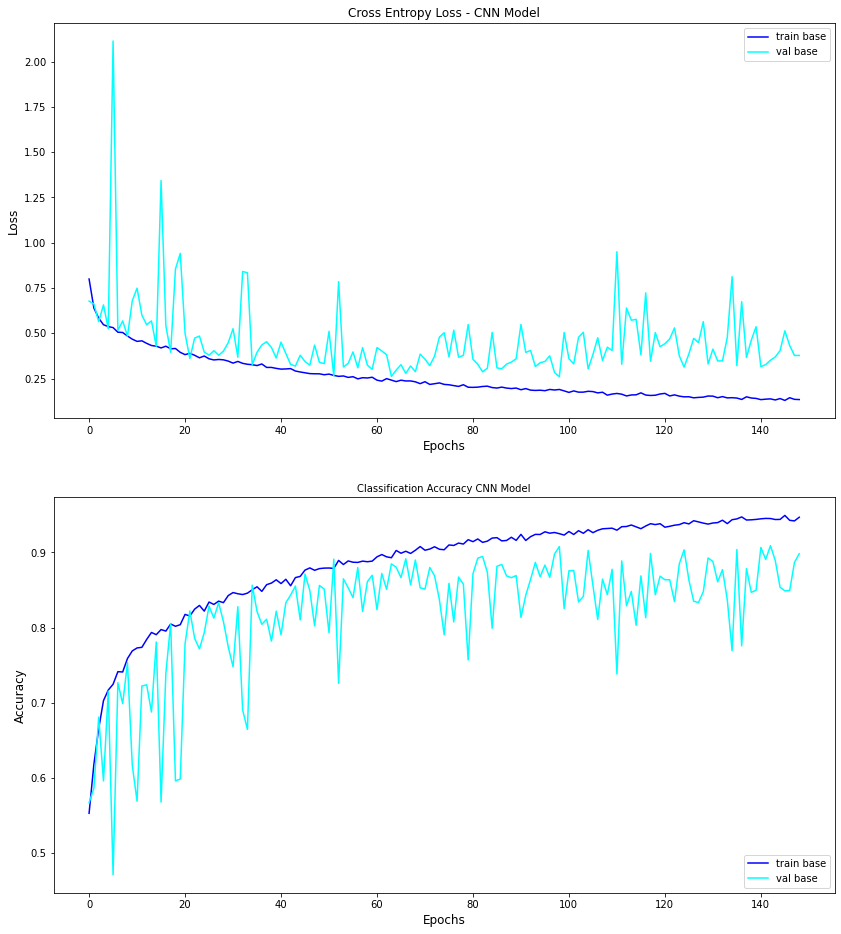

In [17]:
history_plot('CNN Model', history)

In [18]:
model.load_weights('model.h5')

In [19]:
category_names = ["No Defect", "Defect"]

In [20]:
y_test = df_test['defect_label']

STEP_SIZE_TEST = compute_steps_per_epoch(y_test.shape[0])
print('predicting...')

predictions = model.predict(
    test_gen,
    steps = STEP_SIZE_TEST,
    verbose=1)

predicting...
79/79 [==============================] - 2s 20ms/step


In [21]:
y_pred = (predictions > 0.5).astype("int32")

In [22]:
# classification report
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

              precision    recall  f1-score   support

   No Defect       0.92      0.92      0.92      1181
      Defect       0.93      0.93      0.93      1333

    accuracy                           0.92      2514
   macro avg       0.92      0.92      0.92      2514
weighted avg       0.92      0.92      0.92      2514



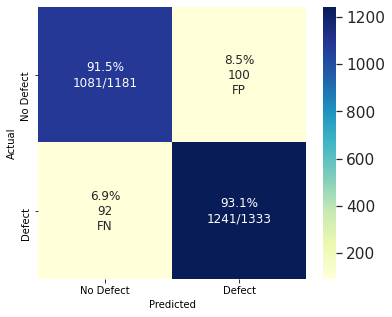

In [23]:
def plot_cm(y_true, y_pred, figsize=(6,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            elif i<j:
                annot[i, j] = '%.1f%%\n%d\nFP' % (p, c)
            else:
                annot[i, j] = '%.1f%%\n%d\nFN' % (p, c)
    #cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm = pd.DataFrame(cm, index=category_names, columns=category_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"fontsize":12})

plot_cm(y_test, y_pred, figsize=(6,5))

ROC AUC=0.974


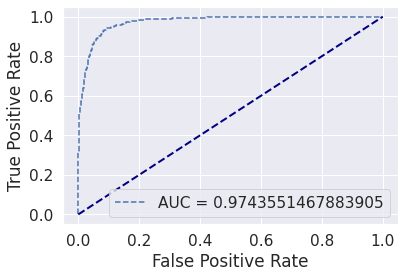

In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# calculate scores
auc = roc_auc_score(y_test, predictions)
# summarize scores
print('ROC AUC=%.3f' % (auc))
# calculate roc curves

ns_fpr, ns_tpr, _ = roc_curve(y_test, predictions)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label="AUC = "+ str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


## Save Model

In [25]:
from datetime import *
filename1 = "severstal-classification-CNNbase" + "-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".h5"
print ("File name is "+filename1)
model.save(filename1, save_format="h5")

File name is severstal-classification-CNNbase-2021-03-19-05-02-19.h5


## Predict submission file

In [26]:
STEP_SIZE_TEST = compute_steps_per_epoch(submission_df.shape[0])
print('predicting...')

submit_test = model.predict(
    submission_gen,
    steps=STEP_SIZE_TEST,
    verbose=1
)

predicting...
173/173 [==============================] - 49s 286ms/step


In [27]:
submission_df['defect_label'] = (submit_test > 0.5).astype("int32")

In [28]:
submission_df.head()

,ImageId,defect_label
0,0000f269f.jpg,0
1,000ccc2ac.jpg,1
2,002451917.jpg,1
3,003c5da97.jpg,1
4,0042e163f.jpg,1


In [29]:
submission_df['defect_label'].value_counts()

1    3588
0    1918
Name: defect_label, dtype: int64

In [30]:
#pd.DataFrame(history.history).to_csv('CNN_BaseModel_history.csv', index=False)
df.to_csv('train_binClass.csv', index=False)
submission_df.to_csv('submission_df_classification_result.csv', index=False)